Carga de múltiples archivos CSV con make_csv_dataset --- 6:59 min
===

* Última modificación: Mayo 6, 2022 | [YouTube](https://youtu.be/WQ5XM4ubK4w)

Importación de librerías
---

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

Descarga de los archivos
---

In [9]:
fonts_zip = tf.keras.utils.get_file(
    "fonts.zip",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip",
    cache_dir=".",
    cache_subdir="/tmp/fonts",
    extract=True,
)

160325632/160313983 [==============================] - 7s 0us/step


In [10]:
import pathlib

font_csvs = sorted(str(p) for p in pathlib.Path("/tmp/fonts").glob("*.csv"))

font_csvs[:10]

['/tmp/fonts/AGENCY.csv',
 '/tmp/fonts/ARIAL.csv',
 '/tmp/fonts/BAITI.csv',
 '/tmp/fonts/BANKGOTHIC.csv',
 '/tmp/fonts/BASKERVILLE.csv',
 '/tmp/fonts/BAUHAUS.csv',
 '/tmp/fonts/BELL.csv',
 '/tmp/fonts/BERLIN.csv',
 '/tmp/fonts/BERNARD.csv',
 '/tmp/fonts/BITSTREAMVERA.csv']

In [12]:
len(font_csvs)

153

Creación del CSV
---

In [11]:
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern="/tmp/fonts/*.csv",
    batch_size=10,
    num_epochs=1,
    num_parallel_reads=20,
    shuffle_buffer_size=10000,
)

Recorrido del archivo
---

In [13]:
for features in fonts_ds.take(1):
    for i, (name, value) in enumerate(features.items()):
        if i > 15:
            break
        print(f"{name:20s}: {value}")
print("...")
print(f"[total: {len(features)} features]")

font                : [b'MONOTXT' b'VIN' b'SITKA' b'GOUDY' b'MONOTXT' b'RAVIE' b'MONOTYPE'
 b'SITKA' b'GUNPLAY' b'VINETA']
fontVariant         : [b'MONOTXT' b'scanned' b'SITKA TEXT' b'GOUDY STOUT' b'MONOTXT' b'RAVIE'
 b'MONOTYPE CORSIVA' b'SITKA TEXT' b'GUNPLAY' b'VINETA BT']
m_label             : [227  49 416  88 243 221 944 323  89  51]
strength            : [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
italic              : [0 0 0 1 0 1 0 0 1 0]
orientation         : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
m_top               : [33  0 53 38 29 21 38 37 32 36]
m_left              : [28  0 23 25 28 32 25 23 35 23]
originalH           : [45 61 45 51 49 71 44 60 47 54]
originalW           : [33  6 50 90 33 65 28 45 40 55]
h                   : [20 20 20 20 20 20 20 20 20 20]
w                   : [20 20 20 20 20 20 20 20 20 20]
r0c0                : [ 1 37  1  1  1  1  1  1  1  1]
r0c1                : [  1  37   1   1   1   1   1   1 182   1]
r0c2                : [  1  37   1   1   1   1   1   1 

Empaquetamiento de pixels
---

In [14]:
import re


def make_images(features):
    image = [None] * 400
    new_feats = {}

    for name, value in features.items():
        match = re.match("r(\d+)c(\d+)", name)
        if match:
            image[int(match.group(1)) * 20 + int(match.group(2))] = value
        else:
            new_feats[name] = value

    image = tf.stack(image, axis=0)
    image = tf.reshape(image, [20, 20, -1])
    new_feats["image"] = image

    return new_feats

Aplicación de la función a cada batch
---

In [15]:
fonts_image_ds = fonts_ds.map(make_images)

for features in fonts_image_ds.take(1):
    break

Gráficos
---

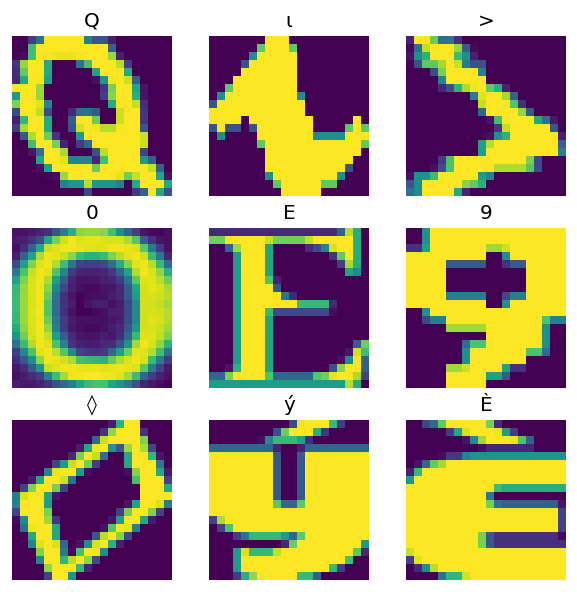

In [16]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6, 6), dpi=120)

for n in range(9):
    plt.subplot(3, 3, n + 1)
    plt.imshow(features["image"][..., n])
    plt.title(chr(features["m_label"][n]))
    plt.axis("off")